## [Exercise](https://www.learnpytorch.io/02_pytorch_classification/#exercises)

### 1 .Make a binary classification dataset with Scikit-Learn's `make_moons()` function.
- For consistency, the dataset should have `1000 samples` and a `random_state=42`.
- Turn the data into PyTorch tensors. Split the data into training and test sets using `train_test_split` with 80% training and 20% testing.

In [1]:
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt

print(torch.__version__)
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

2.1.0+cu121
cuda


In [2]:
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

X_moon, y_moon = make_moons(
    n_samples = 1000,
    noise = 0.2,
    random_state = 42
)

X_moon[:10], y_moon[:10]

(array([[-0.11166654,  0.52022374],
        [ 1.14264982, -0.34257734],
        [ 0.79555796, -0.01144231],
        [ 0.11182668, -0.55193153],
        [-0.81646618,  0.54399604],
        [ 0.66250998, -0.08435588],
        [ 0.27450961, -0.18990367],
        [-0.11555577,  0.53591195],
        [ 1.57236902, -0.33544711],
        [ 0.76398981,  0.96235883]]),
 array([1, 1, 1, 1, 0, 1, 1, 1, 1, 0]))

In [3]:
X_moon = torch.from_numpy(X_moon).type(torch.float)
y_moon = torch.from_numpy(y_moon).type(torch.float)

X_moon, y_moon[:10]

(tensor([[-0.1117,  0.5202],
         [ 1.1426, -0.3426],
         [ 0.7956, -0.0114],
         ...,
         [ 1.7276, -0.4288],
         [-1.0145,  0.1352],
         [ 0.7744,  0.6343]]),
 tensor([1., 1., 1., 1., 0., 1., 1., 1., 1., 0.]))

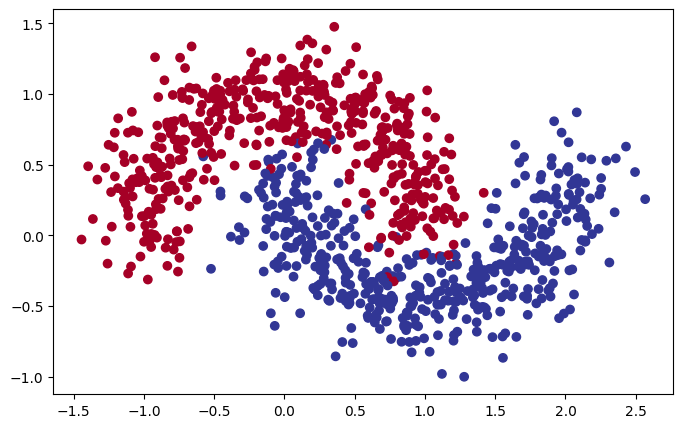

In [4]:
# Plot data
plt.figure(figsize=(8, 5))
plt.scatter(X_moon[:,0],
            X_moon[:,1],
            c = y_moon,
            cmap = plt.cm.RdYlBu);

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X_moon,
                                                    y_moon,
                                                    test_size = 0.2,
                                                    random_state = 42)

### 2. Build a model by subclassing `nn.Module` that incorporates non-linear activation functions and is capable of fitting the data you created in 1.
- Feel free to use any combination of PyTorch layers (linear and non-linear) you want.

In [6]:
print(f'Input_features: {X_moon.shape}')

print(f'Unique output classes: {torch.unique(y_moon)}')
print(f'Output_features: {torch.unique(y_moon).shape}')

Input_features: torch.Size([1000, 2])
Unique output classes: tensor([0., 1.])
Output_features: torch.Size([2])


In [7]:
class MoonModel(nn.Module):
  def __init__(self, input_features, output_features, hidden_units):
    super().__init__()
    self.linear_layer_stack = nn.Sequential(
        nn.Linear(in_features = input_features, out_features = hidden_units),
        nn.ReLU(),
        nn.Linear(in_features = hidden_units, out_features = hidden_units),
        nn.Dropout(0.2),
        nn.Linear(in_features = hidden_units, out_features = hidden_units),
        nn.ReLU(),
        nn.Linear(in_features = hidden_units, out_features = output_features),
    )

  def forward(self, x):
    return self.linear_layer_stack(x)

model = MoonModel(input_features = 2,
                  output_features = 1,
                  hidden_units = 32).to(device)

model

MoonModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=32, bias=True)
    (3): Dropout(p=0.2, inplace=False)
    (4): Linear(in_features=32, out_features=32, bias=True)
    (5): ReLU()
    (6): Linear(in_features=32, out_features=1, bias=True)
  )
)

In [8]:
next(model.parameters()).device

device(type='cuda', index=0)

In [9]:
# Calculate accuracy
def accuracy_fn(y_true, y_pred):
  correct = torch.eq(y_true, y_pred).sum().item()
  acc = (correct/len(y_pred)) * 100
  return acc

### 3. Setup a binary classification compatible loss function and optimizer to use when training the model.

In [10]:
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(params = model.parameters(), lr = 0.01)

### 4. Create a training and testing loop to fit the model you created in 2 to the data you created in 1.
- To measure model accuray, you can create your own accuracy function or use the accuracy function in `TorchMetrics`.
- Train the model for long enough for it to reach over 96% accuracy.
- The training loop should output progress every 10 epochs of the model's training and test set loss and accuracy.

In [11]:
torch.manual_seed(42)

epochs = 100

# Tracking
epoch_count = []
loss_values = []
test_loss_values = []
train_acc_values = []
test_acc_values = []

# Placing data on CUDA
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

# Train
for epoch in range(epochs):
  model.train()
  y_logits = model(X_train).squeeze()
  y_pred = torch.round(torch.sigmoid(y_logits))
  loss = loss_fn(y_logits, y_train)
  acc = accuracy_fn(y_true = y_train, y_pred = y_pred)
  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  # Test
  model.eval()
  with torch.inference_mode():
    test_logits = model(X_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))
    test_loss = loss_fn(test_logits, y_test)
    test_acc = accuracy_fn(y_true = y_test, y_pred = test_pred)

  if epoch % 10 == 0 or epoch == epochs - 1:
    epoch_count.append(epoch)
    loss_values.append(loss)
    test_loss_values.append(test_loss)
    train_acc_values.append(acc)
    test_acc_values.append(test_acc)
    print(f'Epoch: {epoch} ---- Train Loss: {loss:.4f} | Acc: {acc:.2f}% | Test Loss: {test_loss:.4f} | Test Accuracy: {test_acc:.2f}')

Epoch: 0 ---- Train Loss: 0.6869 | Acc: 61.00% | Test Loss: 0.6471 | Test Accuracy: 78.50
Epoch: 10 ---- Train Loss: 0.3491 | Acc: 84.50% | Test Loss: 0.3290 | Test Accuracy: 81.50
Epoch: 20 ---- Train Loss: 0.2566 | Acc: 89.00% | Test Loss: 0.2205 | Test Accuracy: 91.00
Epoch: 30 ---- Train Loss: 0.2017 | Acc: 91.00% | Test Loss: 0.1712 | Test Accuracy: 94.00
Epoch: 40 ---- Train Loss: 0.1352 | Acc: 94.75% | Test Loss: 0.0984 | Test Accuracy: 95.50
Epoch: 50 ---- Train Loss: 0.0898 | Acc: 96.62% | Test Loss: 0.0494 | Test Accuracy: 98.00
Epoch: 60 ---- Train Loss: 0.0811 | Acc: 96.88% | Test Loss: 0.0559 | Test Accuracy: 97.00
Epoch: 70 ---- Train Loss: 0.0665 | Acc: 97.38% | Test Loss: 0.0429 | Test Accuracy: 99.00
Epoch: 80 ---- Train Loss: 0.0641 | Acc: 96.88% | Test Loss: 0.0414 | Test Accuracy: 99.00
Epoch: 90 ---- Train Loss: 0.0630 | Acc: 97.50% | Test Loss: 0.0393 | Test Accuracy: 99.00
Epoch: 99 ---- Train Loss: 0.0651 | Acc: 97.50% | Test Loss: 0.0393 | Test Accuracy: 99.00


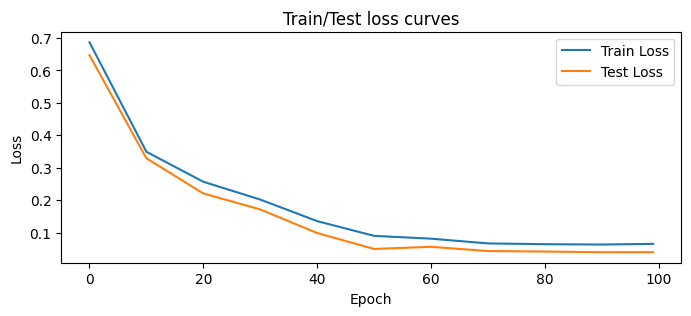

In [12]:
# Plot loss curves
plt.figure(figsize=(8,3))
plt.plot(epoch_count, np.array(torch.tensor(loss_values).numpy()), label="Train Loss")
plt.plot(epoch_count, np.array(torch.tensor(test_loss_values).numpy()), label="Test Loss")
plt.title("Train/Test loss curves")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend();

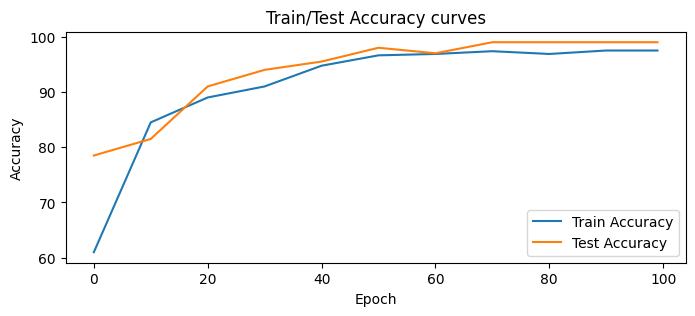

In [13]:
# Plot accuracy curves
plt.figure(figsize=(8,3))
plt.plot(epoch_count, np.array(torch.tensor(train_acc_values).numpy()), label="Train Accuracy")
plt.plot(epoch_count, np.array(torch.tensor(test_acc_values).numpy()), label="Test Accuracy")
plt.title("Train/Test Accuracy curves")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend();

### 5. Make predictions with your trained model and plot them using the `plot_decision_boundary()` function created in this notebook.

In [14]:
model.eval()

with torch.inference_mode():
  # print(X_test.device,next(model.parameters()).device)
  y_preds = torch.round(torch.sigmoid(model.to(device)(X_test))).squeeze()

y_preds[:15], y_test[:15], y_preds[:15] == y_test[:15]

(tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0., 1., 0., 1., 0.],
        device='cuda:0'),
 tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0., 0., 1., 0., 1., 0.],
        device='cuda:0'),
 tensor([True, True, True, True, True, True, True, True, True, True, True, True,
         True, True, True], device='cuda:0'))

In [15]:
import requests
from pathlib import Path

# Download helper function from opensource scripts files
if Path('helper_functions.py').is_file():
  print('helper_functions.py already exists, skipping download')
else:
  print('Downloading helper_function.py')
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open('helper_functions.py', 'wb') as f:
    f.write(request.content)
  print('Download complete')

helper_functions.py already exists, skipping download


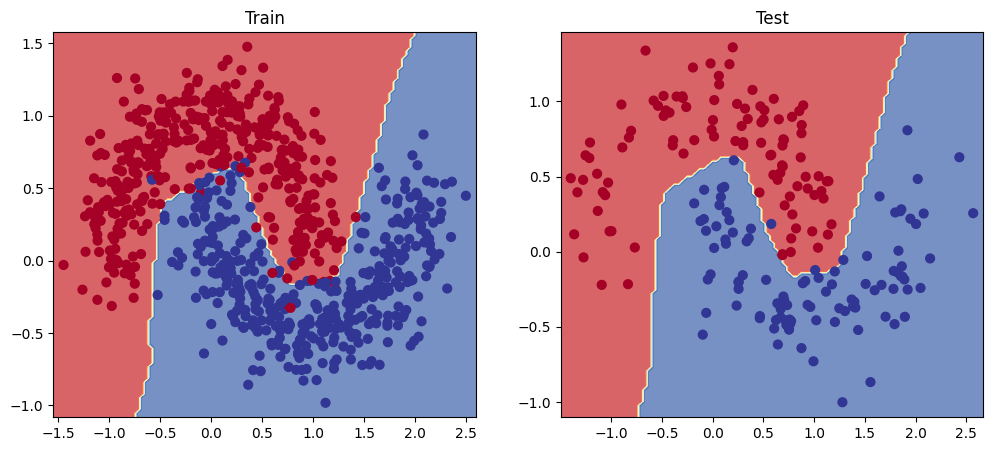

In [23]:
from helper_functions import plot_predictions, plot_decision_boundary

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.title('Train')
plot_decision_boundary(model, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title('Test')
plot_decision_boundary(model, X_test, y_test)

### 6. Replicate the Tanh (hyperbolic tangent) activation function in pure PyTorch.

In [24]:
# Create a tensor
z = torch.arange(-10, 10, 1, dtype=torch.float)

z.dtype

torch.float32

In [25]:
def tanh(z):
	return (np.exp(z) - np.exp(-z)) / (np.exp(z) + np.exp(-z))

tanh(z)

tensor([-1.0000, -1.0000, -1.0000, -1.0000, -1.0000, -0.9999, -0.9993, -0.9951,
        -0.9640, -0.7616,  0.0000,  0.7616,  0.9640,  0.9951,  0.9993,  0.9999,
         1.0000,  1.0000,  1.0000,  1.0000])

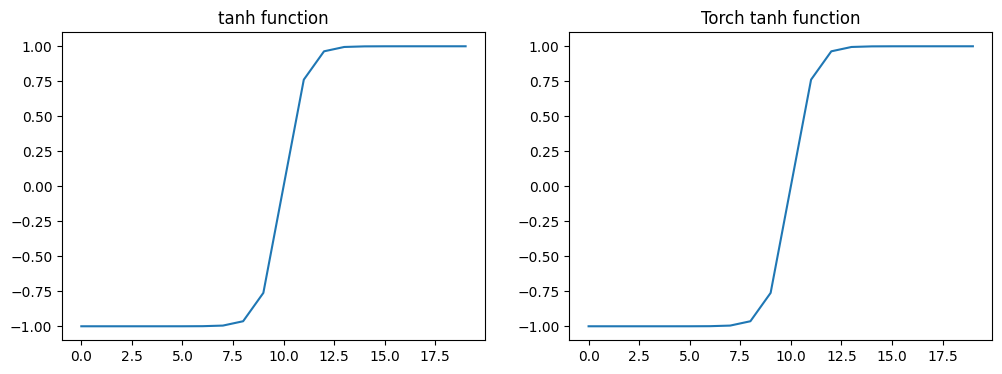

In [28]:
# Plot tanh function
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.title('tanh function')
plt.plot(tanh(z));
plt.subplot(1, 2, 2)
plt.title('Torch tanh function')
plt.plot(torch.tanh(z));